# Introduction

This project explores property prices in Portugal with the goals of:
1. Performing an exploratory data analysis (EDA) to understand the drivers of price variation.
2. Running hypothesis tests to statistically evaluate which property characteristics have a measurable effect on price.
3. Building a machine learning model capable of predicting housing prices accurately.
4. Preparing the model for cloud deployment.

We'll use the Jupyter Notebook as a demonstration of our findings and how we made the model put into deployment.

You can access the deployed application using the link below:
- https://houseprices-img-43887047938.europe-west4.run.app/

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

import helper_functions as hf
import duckdb
import warnings
import scipy.stats as stats


from sklearn.model_selection import train_test_split, GridSearchCV,  KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from statsmodels.stats.weightstats import DescrStatsW

from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor

from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))
warnings.filterwarnings('ignore')



In [2]:
df_raw = pd.read_csv('/Users/guywinfield/PycharmProjects/Data/Portuguese House Prices/portugal_listinigs.csv')

In [3]:
df_raw.head()

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
0,"780,000.000",Vila Real,Valpaços,Carrazedo de Montenegro e Curros,Farm,NC,200.000,"552,450.000",0.000,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,120.000,NaN,NaN,0.000
1,"223,000.000",Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,81.000,1.000,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.000,NaN,NaN,NaN,81.000,NaN,NaN,2.000
2,"228,000.000",Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,108.000,1.000,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.000,NaN,NaN,NaN,108.000,NaN,NaN,2.000
3,"250,000.000",Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.000,1.000,True,1st Floor,NaN,NaN,NaN,NaN,True,NaN,2.000,NaN,NaN,NaN,114.000,NaN,NaN,0.000
4,"250,000.000",Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.000,1.000,True,2nd Floor,NaN,NaN,NaN,NaN,True,NaN,2.000,NaN,NaN,NaN,114.000,NaN,NaN,2.000


In [4]:
df_raw.shape

(135536, 25)

In [5]:
df_raw.dtypes

Price                    float64
District                  object
City                      object
Town                      object
Type                      object
EnergyCertificate         object
GrossArea                float64
TotalArea                float64
Parking                  float64
HasParking                object
Floor                     object
ConstructionYear         float64
EnergyEfficiencyLevel     object
PublishDate               object
Garage                    object
Elevator                  object
ElectricCarsCharging      object
TotalRooms               float64
NumberOfBedrooms         float64
NumberOfWC               float64
ConservationStatus        object
LivingArea               float64
LotSize                  float64
BuiltArea                float64
NumberOfBathrooms        float64
dtype: object

In [6]:
df_raw.isna().sum()

Price                       300
District                      0
City                          0
Town                          2
Type                         16
EnergyCertificate            14
GrossArea                107898
TotalArea                  8383
Parking                     194
HasParking                67321
Floor                    107607
ConstructionYear          47515
EnergyEfficiencyLevel     68247
PublishDate              106297
Garage                    68247
Elevator                     32
ElectricCarsCharging      68247
TotalRooms                62292
NumberOfBedrooms          88495
NumberOfWC                78280
ConservationStatus       116244
LivingArea                30584
LotSize                   95953
BuiltArea                108919
NumberOfBathrooms          6836
dtype: int64

In [7]:
print(f"Duplicated Records: {round(df_raw.duplicated().sum()/len(df_raw),3)*100}% \nTotal Record Dupes: {df_raw.duplicated().sum()}\nTotal Record: {len(df_raw)}")

Duplicated Records: 6.6000000000000005% 
Total Record Dupes: 8913
Total Record: 135536


In [8]:
df_dupes = df_raw[df_raw.duplicated()].sort_values(by=['Price','Town'])

df_dupes.groupby(["Type","District","Price","PublishDate"]).agg(count=("Type", "size")).sort_values(by=['count'], ascending=False).head(20)


count
Type               District         Price       PublishDate                   
Apartment          Faro             299,000.000 2024-04-12 11:35:28.883      5
House              Bragança         60,000.000  2024-09-04 13:59:28.870      5
Land               Setúbal          75,000.000  2024-08-30 09:23:51.570      3
                   Lisboa           199,000.000 2024-02-09 18:51:57.407      3
Garage             Lisboa           44,000.000  2024-11-29 18:55:27.847      3
Other - Commercial Bragança         840,000.000 2025-01-22 09:57:01.777      3
Apartment          Lisboa           948,100.000 2024-02-27 10:25:24.847      3
House              Leiria           49,000.000  2024-08-21 11:27:25.043      3
                   Aveiro           790,000.000 2023-11-15 10:45:30.990      2
Apartment          Viana do Castelo 365,000.000 2024-07-03 16:54:31.677      2
                   Évora            187,500.000 2024-11-04 12:10:19.007      2
                   Viana do Castelo 555,000.000 2024-07-03 16:54:23.073      2
                                    517,000.000 2024-07-03 16:55:14.283      2
House              Castelo Branco   145,000.000 2024-09-30 16:32:06.260      2
                                    325,000.000 2024-09-06 10:59:16.753      2
Apartment          Viana do Castelo 415,000.000 2024-07-03 16:54:50.337      2
                                    260,000.000 2024-07-03 16:53:23.940      2
                                    375,000.000 2024-07-03 16:54:27.247      2
Land               Faro             240,000.000 2024-09-13 13:17:14.847      2
House              Aveiro           720,000.000 2023-11-15 10:49:52.410      2

We could forgive there being multiple properties of the same price and characteristics given that there is no unique identifier per property. However given there are duplicates in the PublishDate which is ms precise makes it very suspicious.

We'll remove all duplicate records going forward as these seem technically driven errors rather than genuine unique houses.



In [9]:
df_dupes[(df_dupes['Price'] == 299000.0	) & (df_dupes['District'] == 'Faro') & (df_dupes['PublishDate'] == '2024-04-12 11:35:28.883')].sort_values(by='PublishDate', ascending=False)

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
114060,"299,000.000",Faro,Vila Real de Santo António,Monte Gordo,Apartment,C,NaN,74.000,0.000,NaN,NaN,"1,988.000",C,2024-04-12 11:35:28.883,False,True,False,4.000,2.000,NaN,NaN,64.000,NaN,74.490,1.000
116535,"299,000.000",Faro,Vila Real de Santo António,Monte Gordo,Apartment,C,NaN,74.000,0.000,NaN,NaN,"1,988.000",C,2024-04-12 11:35:28.883,False,True,False,4.000,2.000,NaN,NaN,64.000,NaN,74.490,1.000
116708,"299,000.000",Faro,Vila Real de Santo António,Monte Gordo,Apartment,C,NaN,74.000,0.000,NaN,NaN,"1,988.000",C,2024-04-12 11:35:28.883,False,True,False,4.000,2.000,NaN,NaN,64.000,NaN,74.490,1.000
129250,"299,000.000",Faro,Vila Real de Santo António,Monte Gordo,Apartment,C,NaN,74.000,0.000,NaN,NaN,"1,988.000",C,2024-04-12 11:35:28.883,False,True,False,4.000,2.000,NaN,NaN,64.000,NaN,74.490,1.000
129503,"299,000.000",Faro,Vila Real de Santo António,Monte Gordo,Apartment,C,NaN,74.000,0.000,NaN,NaN,"1,988.000",C,2024-04-12 11:35:28.883,False,True,False,4.000,2.000,NaN,NaN,64.000,NaN,74.490,1.000


In [10]:
df = df_raw.drop_duplicates(keep='last')

In [11]:
print(df_raw.shape)
print(df.shape)
print(df_dupes.shape)

(135536, 25)
(126623, 25)
(8913, 25)


In [12]:
df.describe()

,Price,GrossArea,TotalArea,Parking,ConstructionYear,TotalRooms,NumberOfBedrooms,NumberOfWC,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
count,"126,340.000","26,014.000","118,815.000","126,477.000","83,305.000","68,806.000","43,823.000","53,276.000","98,117.000","36,904.000","24,838.000","120,125.000"
mean,"370,694.196","2,927.941","549,880.602",0.545,"1,988.804",3.237,2.673,0.433,"1,441.437","57,064.591","3,171.139",1.544
std,"3,933,782.154","118,909.260","178,236,681.551",0.839,26.589,10.818,1.793,1.016,"35,792.582","5,368,910.681","122,528.573",1.739
min,1.000,-7.000,"-7,196,067.000",0.000,"1,900.000",0.000,0.000,-15.000,0.000,0.000,-1.000,-13.000
25%,"85,000.000",100.000,91.000,0.000,"1,972.000",2.000,2.000,0.000,80.000,261.000,103.862,0.000
50%,"210,000.000",163.000,159.000,0.000,"1,993.000",3.000,3.000,0.000,118.000,691.000,167.000,1.000
75%,"390,000.000",296.000,512.000,1.000,"2,008.000",4.000,3.000,1.000,205.000,"2,940.000",300.000,2.000
max,"1,380,000,000.000","12,750,000.000","61,420,071,105.000",3.000,"2,025.000","2,751.000",21.000,59.000,"5,429,000.000","992,301,000.000","12,750,000.000",131.000


## Outlier Removal

To remove outliers we'll logically remove the most obvious ones (Ex: such as having negative amount of rooms) and apply z-scores to our distributions so that we can see the number of standard distributions away from the mean a value might be. This gives us some statistical reasoning to why a value should be treated as an outlier but we still also want to apply some logic.

For instance, most properties are either houses or appartments which have a total area range of between 30m2 to 400m2. On that basis land with 81k m2 could be a huge outlier and would statistically warrant removal but this wouldn't make sense as it's a legitmate size!

In [13]:
df.dtypes

Price                    float64
District                  object
City                      object
Town                      object
Type                      object
EnergyCertificate         object
GrossArea                float64
TotalArea                float64
Parking                  float64
HasParking                object
Floor                     object
ConstructionYear         float64
EnergyEfficiencyLevel     object
PublishDate               object
Garage                    object
Elevator                  object
ElectricCarsCharging      object
TotalRooms               float64
NumberOfBedrooms         float64
NumberOfWC               float64
ConservationStatus        object
LivingArea               float64
LotSize                  float64
BuiltArea                float64
NumberOfBathrooms        float64
dtype: object

In [14]:
cols = []

for col in df.columns:
    if df[col].dtype != 'object':
        cols.append(col)

print(cols)

['Price', 'GrossArea', 'TotalArea', 'Parking', 'ConstructionYear', 'TotalRooms', 'NumberOfBedrooms', 'NumberOfWC', 'LivingArea', 'LotSize', 'BuiltArea', 'NumberOfBathrooms']


In [15]:
df_outliers = df.copy()
z_threshold = 3

for col in cols:
    sigmoid_indices, _, z_scores = hf.find_outliers_sigmoid(df_outliers[col], z_threshold=z_threshold)

    df_outliers[col +'_Z_Score'] = z_scores
    df_outliers[col +'_Is_Z_Outlier'] = df_outliers.index.isin(sigmoid_indices)

df_outliers.head()


,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,Price_Z_Score,Price_Is_Z_Outlier,GrossArea_Z_Score,GrossArea_Is_Z_Outlier,TotalArea_Z_Score,TotalArea_Is_Z_Outlier,Parking_Z_Score,Parking_Is_Z_Outlier,ConstructionYear_Z_Score,ConstructionYear_Is_Z_Outlier,TotalRooms_Z_Score,TotalRooms_Is_Z_Outlier,NumberOfBedrooms_Z_Score,NumberOfBedrooms_Is_Z_Outlier,NumberOfWC_Z_Score,NumberOfWC_Is_Z_Outlier,LivingArea_Z_Score,LivingArea_Is_Z_Outlier,LotSize_Z_Score,LotSize_Is_Z_Outlier,BuiltArea_Z_Score,BuiltArea_Is_Z_Outlier,NumberOfBathrooms_Z_Score,NumberOfBathrooms_Is_Z_Outlier
0,"780,000.000",Vila Real,Valpaços,Carrazedo de Montenegro e Curros,Farm,NC,200.000,"552,450.000",0.000,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,120.000,NaN,NaN,0.000,0.104,False,-0.023,False,0.000,False,-0.649,False,NaN,False,NaN,False,NaN,False,NaN,False,-0.037,False,NaN,False,NaN,False,-0.888,False
1,"223,000.000",Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,81.000,1.000,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.000,NaN,NaN,NaN,81.000,NaN,NaN,2.000,-0.038,False,NaN,False,-0.003,False,0.543,False,NaN,False,-0.114,False,NaN,False,NaN,False,-0.038,False,NaN,False,NaN,False,0.263,False
2,"228,000.000",Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,108.000,1.000,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.000,NaN,NaN,NaN,108.000,NaN,NaN,2.000,-0.036,False,NaN,False,-0.003,False,0.543,False,NaN,False,-0.114,False,NaN,False,NaN,False,-0.037,False,NaN,False,NaN,False,0.263,False
3,"250,000.000",Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.000,1.000,True,1st Floor,NaN,NaN,NaN,NaN,True,NaN,2.000,NaN,NaN,NaN,114.000,NaN,NaN,0.000,-0.031,False,NaN,False,-0.003,False,0.543,False,NaN,False,-0.114,False,NaN,False,NaN,False,-0.037,False,NaN,False,NaN,False,-0.888,False
4,"250,000.000",Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.000,1.000,True,2nd Floor,NaN,NaN,NaN,NaN,True,NaN,2.000,NaN,NaN,NaN,114.000,NaN,NaN,2.000,-0.031,False,NaN,False,-0.003,False,0.543,False,NaN,False,-0.114,False,NaN,False,NaN,False,-0.037,False,NaN,False,NaN,False,0.263,False


In [16]:
cols

['Price',
 'GrossArea',
 'TotalArea',
 'Parking',
 'ConstructionYear',
 'TotalRooms',
 'NumberOfBedrooms',
 'NumberOfWC',
 'LivingArea',
 'LotSize',
 'BuiltArea',
 'NumberOfBathrooms']

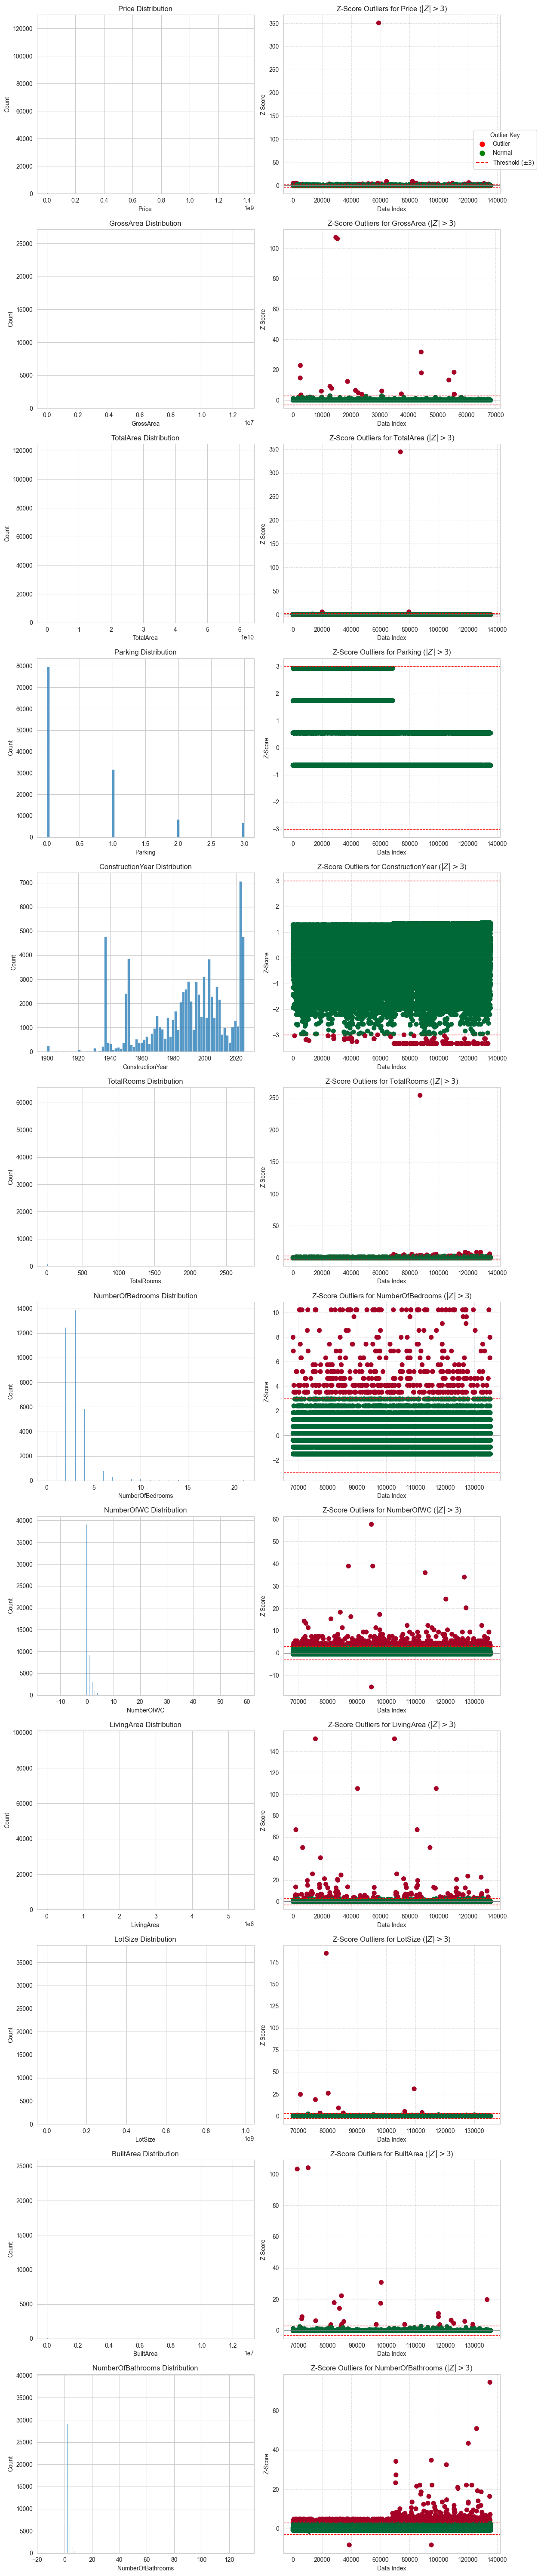

In [17]:
row_count = 0

fig, ax = plt.subplots(len(cols), 2, figsize=(12, 5 * len(cols)))

for col in cols:
    sns.histplot(df_outliers[col], ax=ax[row_count, 0])
    ax[row_count, 0].set_title(f'{col} Distribution')
    ax[row_count, 0].set_xlabel(col)

    ax[row_count, 1].scatter(
        df_outliers.index,
        df_outliers[col + '_Z_Score'],
        c=df_outliers[col + '_Is_Z_Outlier'],
        cmap='RdYlGn_r',
        s=50
    )

    ax[row_count, 1].set_title(f'Z-Score Outliers for {col} ($|Z| > {z_threshold}$)')
    ax[row_count, 1].set_xlabel('Data Index')
    ax[row_count, 1].set_ylabel('Z-Score')

    ax[row_count, 1].axhline(z_threshold, color='red', linestyle='--', linewidth=1)
    ax[row_count, 1].axhline(-z_threshold, color='red', linestyle='--', linewidth=1)
    ax[row_count, 1].axhline(0, color='gray', linestyle='-', linewidth=0.8) # Mean line
    ax[row_count, 1].grid(axis='both', linestyle='--', alpha=0.6)

    row_count += 1


plt.tight_layout()

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Outlier',markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Normal',markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], color='red', linestyle='--', label=f'Threshold ($\pm {z_threshold}$)')
]

fig.legend(handles=legend_elements, loc='upper right', title="Outlier Key",bbox_to_anchor=(1.05, 0.95))

plt.show()

### Outliers Summary

We don't want to be over react to our outliers and remove too much data. Some records will have legitimate reasons, for example we don't consider a house built in 1901 to be an anomlaous outlier.

We'll remove the most obvious issues logically then log scale any fields we feel are neccessary. We'll opt to remove records as oppose to replacing data as we have lots of data to work with a relatively few records to remove.

What we'll remove records with the following z scores for their respective columns:
- Price: 350 z score outliers is unique. Remove > 350
- Total Area: Remove > 350
- Total Rooms: Remove > 250
- Number of WC: Remove < 0
- Lot Size: Remove > 175

We'll investigate further:
- Number of WC > 30 z-score
- Number of Bathrooms > 60 z-score
- Built Area > 100 z-score



In [18]:
# A 1.38$ BILLION house seems expensive for 4 rooms, 3 of which are bathrooms?
# -> DELETE

df_outliers[(df_outliers['Price_Z_Score'] > 350)]

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,Price_Z_Score,Price_Is_Z_Outlier,GrossArea_Z_Score,GrossArea_Is_Z_Outlier,TotalArea_Z_Score,TotalArea_Is_Z_Outlier,Parking_Z_Score,Parking_Is_Z_Outlier,ConstructionYear_Z_Score,ConstructionYear_Is_Z_Outlier,TotalRooms_Z_Score,TotalRooms_Is_Z_Outlier,NumberOfBedrooms_Z_Score,NumberOfBedrooms_Is_Z_Outlier,NumberOfWC_Z_Score,NumberOfWC_Is_Z_Outlier,LivingArea_Z_Score,LivingArea_Is_Z_Outlier,LotSize_Z_Score,LotSize_Is_Z_Outlier,BuiltArea_Z_Score,BuiltArea_Is_Z_Outlier,NumberOfBathrooms_Z_Score,NumberOfBathrooms_Is_Z_Outlier
58787,"1,380,000,000.000",Faro,Faro,Faro (Sé e São Pedro),House,NC,264.000,536.000,1.000,True,Ground Floor,"1,983.000",NaN,NaN,NaN,False,NaN,4.000,NaN,NaN,NaN,180.000,NaN,NaN,3.000,350.713,True,-0.022,False,-0.003,False,0.543,False,-0.218,False,0.071,False,NaN,False,NaN,False,-0.035,False,NaN,False,NaN,False,0.838,False


In [19]:
# Assuming this is in m2 (Data Dictionary doesn't say) this would be the equivalent size of Belgium and the Netherlands combined
# -> DELETE
df_outliers[(df_outliers['TotalArea_Z_Score'] > 350)]

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,Price_Z_Score,Price_Is_Z_Outlier,GrossArea_Z_Score,GrossArea_Is_Z_Outlier,TotalArea_Z_Score,TotalArea_Is_Z_Outlier,Parking_Z_Score,Parking_Is_Z_Outlier,ConstructionYear_Z_Score,ConstructionYear_Is_Z_Outlier,TotalRooms_Z_Score,TotalRooms_Is_Z_Outlier,NumberOfBedrooms_Z_Score,NumberOfBedrooms_Is_Z_Outlier,NumberOfWC_Z_Score,NumberOfWC_Is_Z_Outlier,LivingArea_Z_Score,LivingArea_Is_Z_Outlier,LotSize_Z_Score,LotSize_Is_Z_Outlier,BuiltArea_Z_Score,BuiltArea_Is_Z_Outlier,NumberOfBathrooms_Z_Score,NumberOfBathrooms_Is_Z_Outlier


In [20]:
# 56,000 euros for 2,751.000? Very cheap!
# -> DELETE
df_outliers[(df_outliers['TotalRooms_Z_Score'] > 250)]

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,Price_Z_Score,Price_Is_Z_Outlier,GrossArea_Z_Score,GrossArea_Is_Z_Outlier,TotalArea_Z_Score,TotalArea_Is_Z_Outlier,Parking_Z_Score,Parking_Is_Z_Outlier,ConstructionYear_Z_Score,ConstructionYear_Is_Z_Outlier,TotalRooms_Z_Score,TotalRooms_Is_Z_Outlier,NumberOfBedrooms_Z_Score,NumberOfBedrooms_Is_Z_Outlier,NumberOfWC_Z_Score,NumberOfWC_Is_Z_Outlier,LivingArea_Z_Score,LivingArea_Is_Z_Outlier,LotSize_Z_Score,LotSize_Is_Z_Outlier,BuiltArea_Z_Score,BuiltArea_Is_Z_Outlier,NumberOfBathrooms_Z_Score,NumberOfBathrooms_Is_Z_Outlier
87191,"56,000.000",Leiria,Alcobaça,Maiorga,House,NC,NaN,38.000,0.000,NaN,NaN,"1,937.000",NC,2023-06-27 08:53:11.897,False,False,False,"2,751.000",1.000,0.000,NaN,38.000,"2,751.000",58.000,0.000,-0.080,False,NaN,False,-0.003,False,-0.649,False,-1.948,False,254.000,True,-0.933,False,-0.426,False,-0.039,False,-0.010,False,-0.025,False,-0.888,False


In [21]:
# Based on our distribution we can have negative -z scores. But many types of property don't have WCs (Ex: Storage, land ..etc). For this reason we can apply logic to remove anything that has negative WCs.
# -> DELETE
df_outliers[(df_outliers['NumberOfWC'] < 0)]

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,Price_Z_Score,Price_Is_Z_Outlier,GrossArea_Z_Score,GrossArea_Is_Z_Outlier,TotalArea_Z_Score,TotalArea_Is_Z_Outlier,Parking_Z_Score,Parking_Is_Z_Outlier,ConstructionYear_Z_Score,ConstructionYear_Is_Z_Outlier,TotalRooms_Z_Score,TotalRooms_Is_Z_Outlier,NumberOfBedrooms_Z_Score,NumberOfBedrooms_Is_Z_Outlier,NumberOfWC_Z_Score,NumberOfWC_Is_Z_Outlier,LivingArea_Z_Score,LivingArea_Is_Z_Outlier,LotSize_Z_Score,LotSize_Is_Z_Outlier,BuiltArea_Z_Score,BuiltArea_Is_Z_Outlier,NumberOfBathrooms_Z_Score,NumberOfBathrooms_Is_Z_Outlier
94967,"1,250,000.000",Lisboa,Lisboa,Avenidas Novas,Apartment,NC,NaN,133.000,0.000,NaN,NaN,NaN,NC,NaN,True,True,False,3.000,2.000,-15.000,New,127.000,NaN,NaN,-13.000,0.224,False,NaN,False,-0.003,False,-0.649,False,NaN,False,-0.022,False,-0.376,False,-15.186,True,-0.037,False,NaN,False,NaN,False,-8.365,True


In [22]:
# Assuming this is in m2 (Data Dictionary doesn't say) this would be the bigger than the city of Berlin
# -> DELETE
df_outliers[(df_outliers['LotSize_Z_Score'] > 175)]

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,Price_Z_Score,Price_Is_Z_Outlier,GrossArea_Z_Score,GrossArea_Is_Z_Outlier,TotalArea_Z_Score,TotalArea_Is_Z_Outlier,Parking_Z_Score,Parking_Is_Z_Outlier,ConstructionYear_Z_Score,ConstructionYear_Is_Z_Outlier,TotalRooms_Z_Score,TotalRooms_Is_Z_Outlier,NumberOfBedrooms_Z_Score,NumberOfBedrooms_Is_Z_Outlier,NumberOfWC_Z_Score,NumberOfWC_Is_Z_Outlier,LivingArea_Z_Score,LivingArea_Is_Z_Outlier,LotSize_Z_Score,LotSize_Is_Z_Outlier,BuiltArea_Z_Score,BuiltArea_Is_Z_Outlier,NumberOfBathrooms_Z_Score,NumberOfBathrooms_Is_Z_Outlier
79564,"400,000.000",Coimbra,Figueira da Foz,Lavos,Investment,NC,NaN,"992,301,000.000",0.000,NaN,NaN,"1,977.000",NC,NaN,False,False,False,NaN,NaN,0.000,Needs renovation,NaN,"992,301,000.000",NaN,0.000,0.007,False,NaN,False,5.564,True,-0.649,False,-0.444,False,NaN,False,NaN,False,-0.426,False,NaN,False,184.813,True,NaN,False,-0.888,False


### Further Investigation

In [23]:
# These tend to be building with multiple occupants such as Hotels, Residency buildings so we'll keep them. However there is 1 appartment with 59 bathrooms that we should remove.
df_outliers[(df_outliers['NumberOfWC_Z_Score'] > 30)]

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,Price_Z_Score,Price_Is_Z_Outlier,GrossArea_Z_Score,GrossArea_Is_Z_Outlier,TotalArea_Z_Score,TotalArea_Is_Z_Outlier,Parking_Z_Score,Parking_Is_Z_Outlier,ConstructionYear_Z_Score,ConstructionYear_Is_Z_Outlier,TotalRooms_Z_Score,TotalRooms_Is_Z_Outlier,NumberOfBedrooms_Z_Score,NumberOfBedrooms_Is_Z_Outlier,NumberOfWC_Z_Score,NumberOfWC_Is_Z_Outlier,LivingArea_Z_Score,LivingArea_Is_Z_Outlier,LotSize_Z_Score,LotSize_Is_Z_Outlier,BuiltArea_Z_Score,BuiltArea_Is_Z_Outlier,NumberOfBathrooms_Z_Score,NumberOfBathrooms_Is_Z_Outlier
87133,"850,000.000",Leiria,Caldas da Rainha,"Caldas da Rainha - Nossa Senhora do Pópulo, Co...",Other - Residential,NC,NaN,812.000,0.000,NaN,NaN,NaN,NC,NaN,False,True,False,49.000,21.000,40.000,NaN,NaN,NaN,NaN,40.000,0.122,False,NaN,False,-0.003,False,-0.649,False,NaN,False,4.230,True,10.219,True,38.934,True,NaN,False,NaN,False,NaN,False,22.118,True
94955,"1,700,000.000",Lisboa,Lisboa,Avenidas Novas,Apartment,NC,NaN,176.000,0.000,NaN,NaN,NaN,NC,NaN,True,True,False,5.000,4.000,59.000,New,168.000,NaN,NaN,62.000,0.338,False,NaN,False,-0.003,False,-0.649,False,NaN,False,0.163,False,0.740,False,57.630,True,-0.036,False,NaN,False,NaN,False,34.772,True
95420,"4,000,000.000",Lisboa,Lisboa,Olivais,Building,NC,NaN,"3,278.000",0.000,NaN,NaN,"1,949.000",NC,NaN,False,False,False,NaN,21.000,40.000,Needs renovation,"3,278.000",NaN,"3,278.000",40.000,0.923,False,NaN,False,-0.003,False,-0.649,False,-1.497,False,NaN,False,10.219,True,38.934,True,0.051,False,NaN,False,0.001,False,22.118,True
113278,"1,980,000.000",Viana do Castelo,Valença,Gandra e Taião,Hotel,C,NaN,"3,051.000",1.000,NaN,NaN,"2,007.000",C,NaN,False,True,False,37.000,21.000,37.000,NaN,NaN,"9,500.000","3,436.000",37.000,0.409,False,NaN,False,-0.003,False,0.543,False,0.684,False,3.121,True,10.219,True,35.982,True,NaN,False,-0.009,False,0.002,False,20.393,True
126646,"1,200,000.000",Coimbra,Figueira da Foz,Buarcos e São Julião,Hotel,NC,NaN,"1,510.000",0.000,NaN,NaN,"1,946.000",NC,NaN,True,False,False,35.000,21.000,35.000,Used,NaN,"1,267.000",NaN,35.000,0.211,False,NaN,False,-0.003,False,-0.649,False,-1.610,False,2.936,False,10.219,True,34.014,True,NaN,False,-0.010,False,NaN,False,19.243,True


In [24]:
# 2 bedroom house with 131 bathrooms?
# -> DELETE
df_outliers[(df_outliers['NumberOfBathrooms_Z_Score'] > 60)]


,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,Price_Z_Score,Price_Is_Z_Outlier,GrossArea_Z_Score,GrossArea_Is_Z_Outlier,TotalArea_Z_Score,TotalArea_Is_Z_Outlier,Parking_Z_Score,Parking_Is_Z_Outlier,ConstructionYear_Z_Score,ConstructionYear_Is_Z_Outlier,TotalRooms_Z_Score,TotalRooms_Is_Z_Outlier,NumberOfBedrooms_Z_Score,NumberOfBedrooms_Is_Z_Outlier,NumberOfWC_Z_Score,NumberOfWC_Is_Z_Outlier,LivingArea_Z_Score,LivingArea_Is_Z_Outlier,LotSize_Z_Score,LotSize_Is_Z_Outlier,BuiltArea_Z_Score,BuiltArea_Is_Z_Outlier,NumberOfBathrooms_Z_Score,NumberOfBathrooms_Is_Z_Outlier
135169,"55,000.000",Portalegre,Alter do Chão,Cunheira,House,NC,NaN,41.000,0.000,NaN,NaN,"1,970.000",NC,2025-01-23 17:19:52.243,False,False,False,2.000,1.000,1.000,NaN,100.000,101.000,130.000,131.000,-0.080,False,NaN,False,-0.003,False,-0.649,False,-0.707,False,-0.114,False,-0.933,False,0.558,False,-0.037,False,-0.011,False,-0.025,False,74.457,True


In [25]:
# The average Amazon warehouse if between 70,000 and 100,000. Both these records would be far beyond that size at a price which doesn't seem representative
# -> DELETE
df_outliers[(df_outliers['BuiltArea_Z_Score'] > 100)]

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,Price_Z_Score,Price_Is_Z_Outlier,GrossArea_Z_Score,GrossArea_Is_Z_Outlier,TotalArea_Z_Score,TotalArea_Is_Z_Outlier,Parking_Z_Score,Parking_Is_Z_Outlier,ConstructionYear_Z_Score,ConstructionYear_Is_Z_Outlier,TotalRooms_Z_Score,TotalRooms_Is_Z_Outlier,NumberOfBedrooms_Z_Score,NumberOfBedrooms_Is_Z_Outlier,NumberOfWC_Z_Score,NumberOfWC_Is_Z_Outlier,LivingArea_Z_Score,LivingArea_Is_Z_Outlier,LotSize_Z_Score,LotSize_Is_Z_Outlier,BuiltArea_Z_Score,BuiltArea_Is_Z_Outlier,NumberOfBathrooms_Z_Score,NumberOfBathrooms_Is_Z_Outlier
69671,"2,200,000.000",Aveiro,Águeda,Aguada de Cima,Warehouse,NC,NaN,"3,442,000.000",0.000,NaN,NaN,"2,010.000",NC,2024-01-30 18:20:50.550,False,False,False,NaN,NaN,0.000,Used,"5,429,000.000","5,732,000.000","12,650,000.000",0.000,0.465,False,NaN,False,0.016,False,-0.649,False,0.797,False,NaN,False,NaN,False,-0.426,False,151.639,True,1.057,False,103.215,True,-0.888,False
73400,"775,000.000",Braga,Braga,Tebosa,Industrial,NC,NaN,"12,750,000.000",0.000,NaN,NaN,NaN,NC,2024-02-12 19:29:21.207,False,False,False,NaN,NaN,NaN,NaN,NaN,"12,750,000.000","12,750,000.000",NaN,0.103,False,NaN,False,0.068,False,-0.649,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,2.364,False,104.031,True,NaN,False


In [26]:
# Delete Records
df_outliers.drop(df_outliers[(df_outliers['Price_Z_Score'] > 350)].index,inplace=True)
df_outliers.drop(df_outliers[(df_outliers['TotalArea_Z_Score'] > 350)].index,inplace=True)
df_outliers.drop(df_outliers[(df_outliers['TotalRooms_Z_Score'] > 250)].index,inplace=True)
df_outliers.drop(df_outliers[(df_outliers['NumberOfWC'] < 0)].index,inplace=True)
df_outliers.drop(df_outliers[(df_outliers['LotSize_Z_Score'] > 175)].index,inplace=True)

# Further Investigation Records
df_outliers.drop(94955,inplace=True)
df_outliers.drop(df_outliers[(df_outliers['NumberOfBathrooms_Z_Score'] > 60)].index,inplace=True)
df_outliers.drop(df_outliers[(df_outliers['BuiltArea_Z_Score'] > 60)].index,inplace=True)

In [27]:
df = df_outliers[df_raw.columns].copy()

In [28]:
print(df.shape)
print(df.dtypes)


(126615, 25)
Price                    float64
District                  object
City                      object
Town                      object
Type                      object
EnergyCertificate         object
GrossArea                float64
TotalArea                float64
Parking                  float64
HasParking                object
Floor                     object
ConstructionYear         float64
EnergyEfficiencyLevel     object
PublishDate               object
Garage                    object
Elevator                  object
ElectricCarsCharging      object
TotalRooms               float64
NumberOfBedrooms         float64
NumberOfWC               float64
ConservationStatus        object
LivingArea               float64
LotSize                  float64
BuiltArea                float64
NumberOfBathrooms        float64
dtype: object


In [29]:
pd.DataFrame(df.isna().sum() / len(df)).sort_values(by=0,ascending=False)

,0
ConservationStatus,0.857
BuiltArea,0.804
GrossArea,0.795
Floor,0.794
PublishDate,0.780
LotSize,0.709
NumberOfBedrooms,0.654
NumberOfWC,0.579
EnergyEfficiencyLevel,0.505
ElectricCarsCharging,0.505


The categorical data looks reasonably sensible without any noticeable data entry errors, outlier categories or anything suspicious. Based on what we've seen so far of the data we'll remove some colunms we think are duplicative or aren't useful.

**Remaining Cleaning**
- Create `FloorNum` for int representation
- Add 'NA' to remaining fields that have null values
- Remove duplicate fields such as:
    - EnergyCertificateLevel, Town


**Feature Engineering**

Based the data we've seen so far here are some extra columns we could add into our data:
- `FloorNum` :	Floor number as int
- `AgeAtSale` :	Current Year - ConstructionYear
- `IsLisbonPorto` :	Flag (1/0) if District is Lisbon or Porto.
- `WCRatio` :	NumberOfWC / (TotalRooms - 1)





In [30]:
cols = []

for col in df.columns:
    if df[col].dtype == 'object'  and col not in ['PublishDate','District','Town','City']:
        print(pd.DataFrame(df[col].value_counts(dropna=False)))



                     count
Type                      
Apartment            43997
House                34539
Land                 29535
Store                 5063
Farm                  3763
Building              2400
Transfer of lease     1589
Warehouse             1341
Garage                 885
Other - Commercial     765
Office                 696
Other - Residential    556
Industrial             399
Duplex                 371
Investment             221
Storage                166
Hotel                  149
Studio                  66
Estate                  60
Mansion                 33
NaN                     15
Manor                    6
                   count
EnergyCertificate       
NC                 56464
C                  15769
D                  15055
E                  10541
A                   8875
F                   7244
B-                  4267
B                   4058
A+                  3845
G                    425
No Certificate        42
Not available         17
Na

In [31]:
# Connect (in-memory or to a local DB file)
con = duckdb.connect()

query = """

WITH base AS (

    SELECT
        -- Location
        District,
        IF(City IN ('Lisboa','Porto'),1,0) AS IsLisbonOrPorto,

        -- Property Characteristics
        COALESCE(Type, 'NA') AS Type,
        ConstructionYear,
        (COALESCE(EXTRACT(YEAR FROM DATE(PublishDate)),2024) - ConstructionYear) AS AgeAtSale,

        CASE
            WHEN Floor IN ('Basement Level','Basement') THEN -1
            WHEN Floor IN ('Ground Floor','Duplex','Triplex','Service Floor','Mezzanine') THEN 0
            WHEN Floor = '1st Floor' THEN 1
            WHEN Floor = '2nd Floor' THEN 2
            WHEN Floor = '3rd Floor' THEN 3
            WHEN Floor = '4th Floor' THEN 4
            WHEN Floor = '5th Floor' THEN 5
            WHEN Floor = '6th Floor' THEN 6
            WHEN Floor = '7th Floor' THEN 7
            WHEN Floor = '8th Floor' THEN 8
            WHEN Floor = '9th Floor' THEN 9
            WHEN Floor = '10th Floor' THEN 10
            WHEN Floor = 'Above 10th Floor' THEN 11
            WHEN Floor IS NULL THEN 0
            ELSE NULL
        END AS FloorNum,

        TotalArea,
        LivingArea,

        -- Amenities
        COALESCE(CAST(Parking AS string), 'NA') AS Parking,
        COALESCE(CAST(Garage AS string), 'NA') AS Garage,
        COALESCE(CAST(Elevator AS string), 'NA') AS Elevator,
        COALESCE(CAST(ElectricCarsCharging AS string), 'NA') AS ElectricCarsCharging,

        -- Rooms
        TotalRooms,
        GREATEST(NumberOfBathrooms, NumberOfWC) AS NumberOfWashrooms,

        CASE
            WHEN TotalRooms IS NULL OR NumberOfWashrooms IS NULL THEN NULL
            WHEN TotalRooms = 0 THEN NULL
            ELSE (GREATEST(NumberOfBathrooms, NumberOfWC, 0) / TotalRooms)
        END AS WashroomRatio,

        -- Condition
        CASE
            WHEN EnergyCertificate IS NULL THEN 'NA'
            WHEN EnergyCertificate IN ('No Certificate','Not available') THEN 'NA'
            ELSE EnergyCertificate
        END AS EnergyCertificate,
        COALESCE(ConservationStatus, 'NA') AS ConservationStatus,




        -- Price
        Price,

    FROM df
)

SELECT *
FROM base

"""

df_new = con.execute(query).fetchdf()



In [32]:
df = df_new.copy()

In [33]:
print(pd.DataFrame(df.isna().sum() / len(df)).sort_values(by=0,ascending=False))

                         0
WashroomRatio        0.511
TotalRooms           0.457
ConstructionYear     0.342
AgeAtSale            0.342
LivingArea           0.225
TotalArea            0.062
NumberOfWashrooms    0.051
Price                0.002
FloorNum             0.001
ConservationStatus   0.000
EnergyCertificate    0.000
District             0.000
ElectricCarsCharging 0.000
Elevator             0.000
IsLisbonOrPorto      0.000
Parking              0.000
Type                 0.000
Garage               0.000


In [34]:
df = df.dropna(subset=['Price'])

In [35]:
# Wipe unneeded dataframe from Memory
lst = [df_dupes, df_outliers, df_new]
del df_dupes, df_outliers, df_new
del lst


# Exploratory Data Analysis

In [36]:
df.head()

,District,IsLisbonOrPorto,Type,ConstructionYear,AgeAtSale,FloorNum,TotalArea,LivingArea,Parking,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfWashrooms,WashroomRatio,EnergyCertificate,ConservationStatus,Price
0,Vila Real,0,Farm,NaN,NaN,0,"552,450.000",120.000,0.0,NA,false,NA,NaN,0.000,NaN,NC,NA,"780,000.000"
1,Faro,0,Apartment,NaN,NaN,0,81.000,81.000,1.0,NA,true,NA,2.000,2.000,1.000,A+,NA,"223,000.000"
2,Faro,0,Apartment,NaN,NaN,0,108.000,108.000,1.0,NA,true,NA,2.000,2.000,1.000,A+,NA,"228,000.000"
3,Faro,0,Apartment,NaN,NaN,1,114.000,114.000,1.0,NA,true,NA,2.000,0.000,0.000,A+,NA,"250,000.000"
4,Faro,0,Apartment,NaN,NaN,2,114.000,114.000,1.0,NA,true,NA,2.000,2.000,1.000,A+,NA,"250,000.000"


In [37]:
type_summary = df.groupby('Type').agg(median_price=("Price", "median"),avg_price=("Price", "mean"),count=("Price", "count"),total_market_value=("Price", "sum")).sort_values("median_price", ascending=False).reset_index()
type_summary['vol_pct_share'] = type_summary['count'] / type_summary['count'].sum()
type_summary['value_pct_share'] = type_summary['total_market_value'] / type_summary['total_market_value'].sum()
type_summary['pct_share_diff'] = type_summary['value_pct_share'] - type_summary['vol_pct_share']
type_summary.sort_values("pct_share_diff", ascending=False,inplace=True)

type_summary

,Type,median_price,avg_price,count,total_market_value,vol_pct_share,value_pct_share,pct_share_diff
11,House,"250,000.000","415,267.007",34462,"14,310,931,595.000",0.273,0.315,0.042
4,Building,"550,000.000","854,171.725",2392,"2,043,178,766.000",0.019,0.045,0.026
10,Farm,"260,000.000","593,649.933",3757,"2,230,342,798.000",0.030,0.049,0.019
8,Apartment,"279,000.000","373,129.906",43859,"16,365,104,557.870",0.347,0.360,0.013
2,Hotel,"1,600,000.000","2,857,393.243",148,"422,894,200.000",0.001,0.009,0.008
9,Warehouse,"275,000.000","607,500.187",1338,"812,835,250.000",0.011,0.018,0.007
5,Industrial,"488,475.000","940,001.349",398,"374,120,537.000",0.003,0.008,0.005
6,Duplex,"475,000.000","800,985.135",363,"290,757,604.000",0.003,0.006,0.004
7,Investment,"475,000.000","1,077,683.235",221,"238,167,995.000",0.002,0.005,0.003
0,Estate,"2,047,500.000","2,964,896.667",60,"177,893,800.000",0.000,0.004,0.003


The dataset shows that apartments are the most common listing, making up 35% of all records, followed by houses at 27% and land at 23%. Together, these three categories account for 85% of all property listings, giving us a strong foundation for understanding the overall market.

From a pricing perspective, both apartments and houses show a strong right-skewed distribution, where a relatively smaller number of high-value properties pull the mean upward.

- Apartments: The higher median price is expected, as apartments are more often located in urban areas, where property values are typically higher.
- Houses: The lower median price reflects the large number of houses in rural regions, which tend to be cheaper.
- Land: As with houses, land value depends heavily on location, which drives sharp variation and contributes to the pronounced right skew.

Let's see if this theory runs true by adding `IsLisbonOrPorto` to help divide between rural and non rurual. Although this isn't a perfect measurment it removes the most highly urban districts from our data and shoudl give us at least an indication!

In [38]:
df.groupby(['Type','IsLisbonOrPorto']).agg(median_price=("Price", "median"),avg_price=("Price", "mean"),count=("Price", "count"),total_market_value=("Price", "sum")).sort_values(['Type','IsLisbonOrPorto'], ascending=True).reset_index()


,Type,IsLisbonOrPorto,median_price,avg_price,count,total_market_value
0,Apartment,0,"249,000.000","317,637.417",34191,"10,860,340,915.870"
1,Apartment,1,"395,900.000","569,379.773",9668,"5,504,763,642.000"
2,Building,0,"380,000.000","584,604.743",1664,"972,782,293.000"
3,Building,1,"995,000.000","1,470,324.826",728,"1,070,396,473.000"
4,Duplex,0,"426,500.000","649,728.482",274,"178,025,604.000"
5,Duplex,1,"935,000.000","1,266,651.685",89,"112,732,000.000"
6,Estate,0,"2,047,500.000","2,964,896.667",60,"177,893,800.000"
7,Farm,0,"260,000.000","591,811.182",3756,"2,222,842,798.000"
8,Farm,1,"7,500,000.000","7,500,000.000",1,"7,500,000.000"
9,Garage,0,"22,000.000","37,851.006",804,"30,432,209.000"


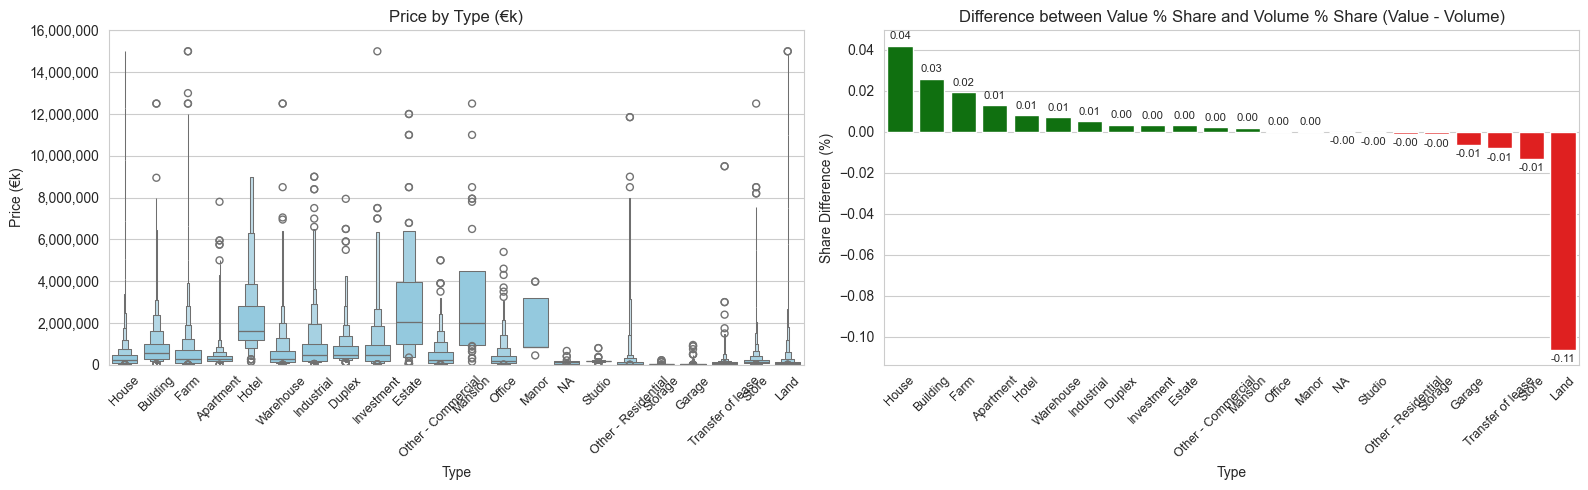

In [39]:
import matplotlib

# This is so we can have the same Type order in both charts
type_order = (
    type_summary
    .sort_values("pct_share_diff", ascending=False)["Type"]
    .tolist()
)

# 2️⃣ Recalculate colours in sorted order
colors = ['green' if x > 0 else 'red'
          for x in type_summary.set_index("Type")
                              .loc[type_order]["pct_share_diff"]]

fig, ax = plt.subplots(1, 2, figsize=(16, 5))


# =========================
# 1️⃣ LEFT CHART — Boxplot
sns.boxenplot(
    data=df,
    x='Type',
    y='Price',
    order=type_order,          # <-- consistent ordering
    ax=ax[0],
    color='skyblue'
)

ax[0].set_title("Price by Type (€k)")
ax[0].set_xlabel("Type")
ax[0].set_ylabel("Price (€k)")
ax[0].tick_params(axis='x', rotation=45, labelsize=9)
ax[0].set(ylim=(0, 16_000_000))
ax[0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))




# ==================================================
# 2️⃣ RIGHT CHART — Barplot (Value - Volume % Share)
# ==================================================
sns.barplot(
    data=type_summary,
    x='Type',
    y='pct_share_diff',
    order=type_order,          # <-- same order here
    palette=colors,
    ax=ax[1]
)

ax[1].set_title("Difference between Value % Share and Volume % Share (Value - Volume)")
ax[1].set_xlabel("Type")
ax[1].set_ylabel("Share Difference (%)")
ax[1].tick_params(axis='x', rotation=45, labelsize=9)

# Add data labels
for container in ax[1].containers:
    ax[1].bar_label(container, fmt="%.2f", fontsize=8, padding=3)

plt.tight_layout()
plt.show()


### What is this telling us?

On the left we're looking at the distribution of Price by each different Type of property. We can see there's a massive variation in Price across the different types but the typical property is less than €1,000,000. This chart on the left doesn't tell us much more than there's a lot of variation in the data, it doesn't tell us if any of these properties are overrepresented in the Housing Market in value terms.

On the right we take a look at the total value of property listings by type as a % of all properties listed and subtract the % share of volume for those listed properties. If all property types were valued roughly the same (For example if they had the same price per m2) then we'd expect these values to be the same, anything with a positive + value would be valued higher than their proportion of listing and anything negative - vice-versa.


What we see is:
- Houses are +4ppt more valued than the space they take up in listing
- Land is hugely undervalued with -.11ppts

We could see this as a balance between supply/demand. There is much more land available for sale than there is for demand and vice versa for Houses.



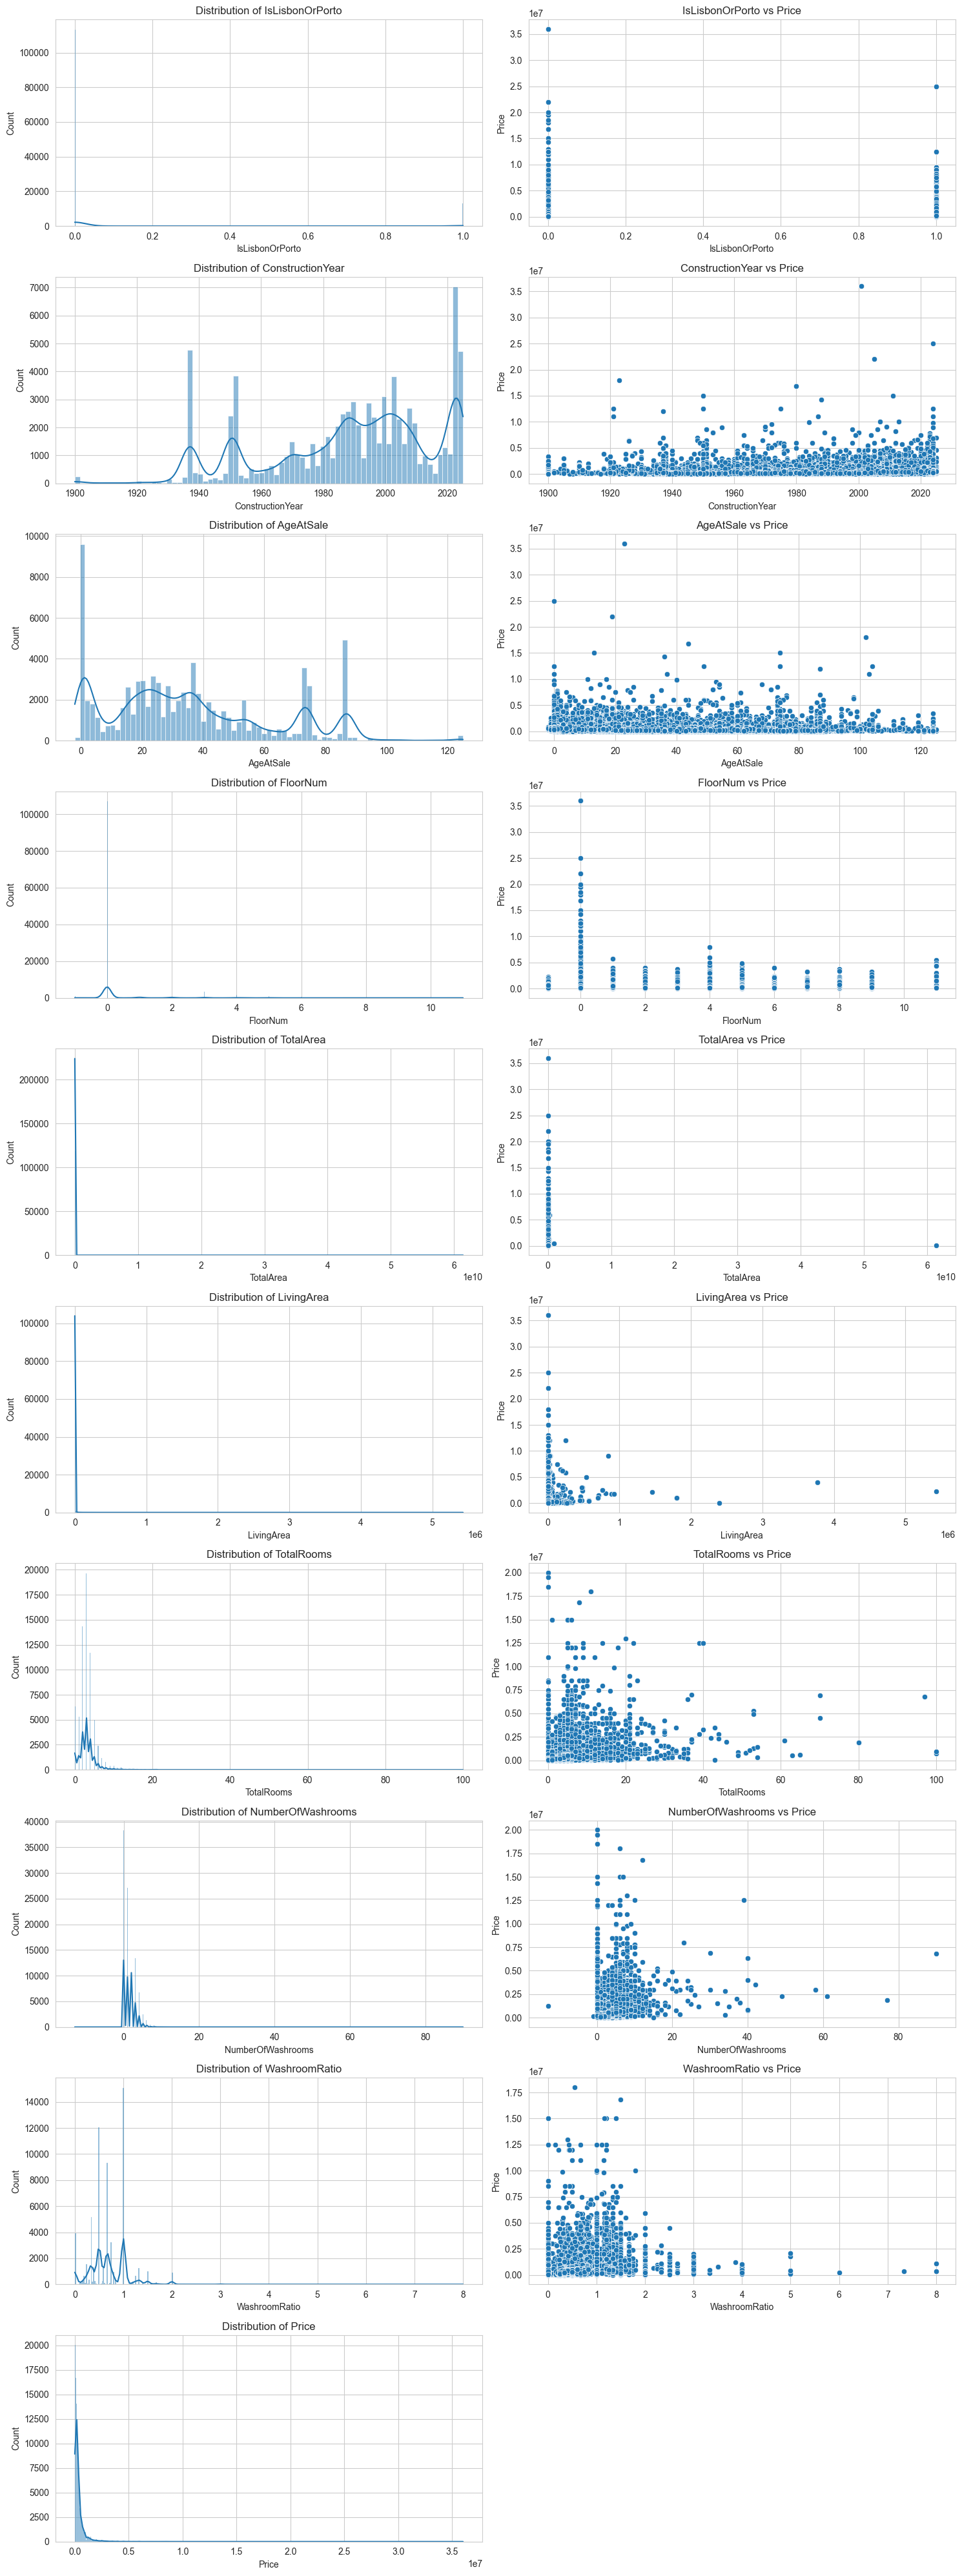

In [40]:
numeric_cols = df.select_dtypes(exclude='object').columns

fig, ax = plt.subplots(len(numeric_cols), 2, figsize=(15, 4 * len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    # Left Chart showing overall col distribution
    sns.histplot(df[col].dropna(), ax=ax[i, 0], kde=True)

    ax[i, 0].set_title(f"Distribution of {col}")

    # Right Chart showing col relationship with price
    if 'Price' in df.columns and col != 'Price':
        sns.scatterplot(data=df, x=col, y='Price', ax=ax[i, 1])
        ax[i, 1].set_title(f"{col} vs Price")
    else:
        ax[i, 1].set_visible(False)

plt.tight_layout()
plt.show()

When looking at how price relates to the other features, there’s a lot of variation across both the continuous and the discrete fields. That’s probably because the dataset includes all kinds of different properties, which naturally adds a lot of noise.

Even so, a few things stand out more clearly such as especially the relationship between Construction Year, Total Rooms, and price.

In [41]:
df.head()

,District,IsLisbonOrPorto,Type,ConstructionYear,AgeAtSale,FloorNum,TotalArea,LivingArea,Parking,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfWashrooms,WashroomRatio,EnergyCertificate,ConservationStatus,Price
0,Vila Real,0,Farm,NaN,NaN,0,"552,450.000",120.000,0.0,NA,false,NA,NaN,0.000,NaN,NC,NA,"780,000.000"
1,Faro,0,Apartment,NaN,NaN,0,81.000,81.000,1.0,NA,true,NA,2.000,2.000,1.000,A+,NA,"223,000.000"
2,Faro,0,Apartment,NaN,NaN,0,108.000,108.000,1.0,NA,true,NA,2.000,2.000,1.000,A+,NA,"228,000.000"
3,Faro,0,Apartment,NaN,NaN,1,114.000,114.000,1.0,NA,true,NA,2.000,0.000,0.000,A+,NA,"250,000.000"
4,Faro,0,Apartment,NaN,NaN,2,114.000,114.000,1.0,NA,true,NA,2.000,2.000,1.000,A+,NA,"250,000.000"


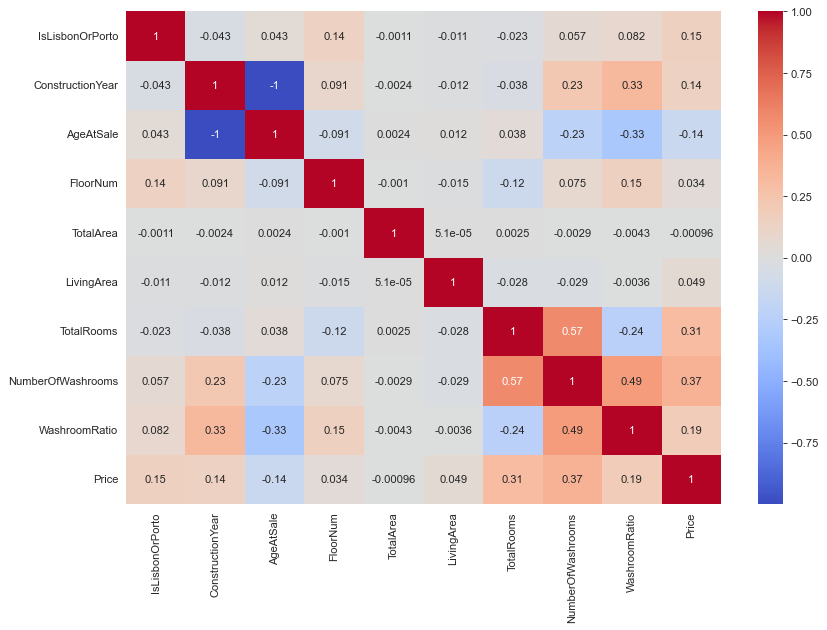

In [42]:
plt.figure(figsize=(12, 8), dpi=80)

sns.heatmap(data=df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

There also seem to be some fairly clear linear relationships with price especially with the total number of rooms and the number of washrooms. The washroom ratio shows a bit of a trend too, at least within the continuous parts of the dataset.

Let's take another look using Spearman's correlation coefficient as we could see in our EDA not all relationships are likely to be linear



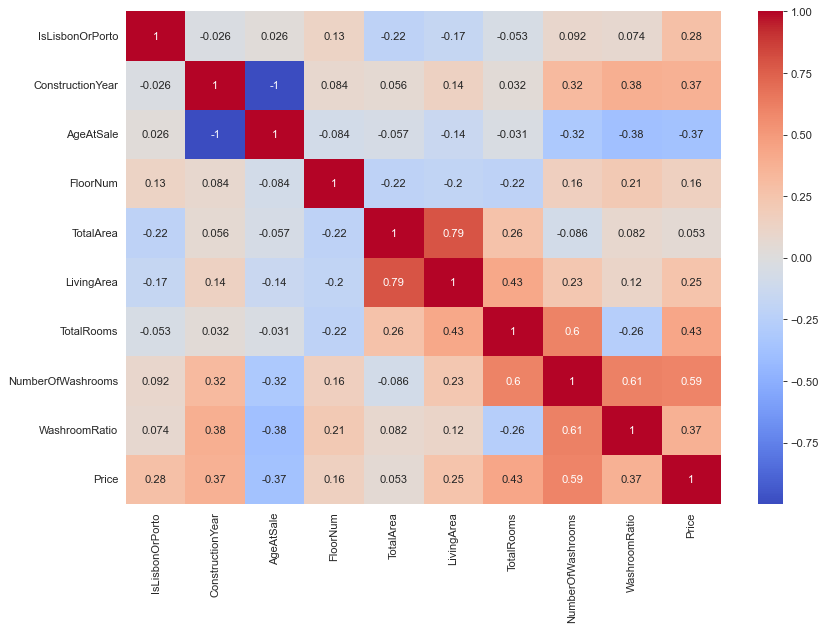

In [43]:
plt.figure(figsize=(12, 8), dpi=80)

sns.heatmap(data=df[numeric_cols].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.show()

Our correlation matrix gives us much higher coefficient values when using the spearman. This means the relationship between our variables isn’t really a straight line (which Pearson measures), but it does follow a consistent order or ranking pattern (which Spearman picks up on).

We'll note this going forward for when we start our machine learning. Any linear regressions probably won't give us the best results!

In [44]:
df[numeric_cols].corr(method='spearman')['Price'].sort_values(ascending=False)

Price                1.000
NumberOfWashrooms    0.594
TotalRooms           0.430
ConstructionYear     0.370
WashroomRatio        0.369
IsLisbonOrPorto      0.279
LivingArea           0.251
FloorNum             0.156
TotalArea            0.053
AgeAtSale           -0.369
Name: Price, dtype: float64

In [45]:
categorical_cols = df.select_dtypes(include='object').columns
categorical_cols

Index(['District', 'Type', 'Parking', 'Garage', 'Elevator',
       'ElectricCarsCharging', 'EnergyCertificate', 'ConservationStatus'],
      dtype='object')

Let's take a look to see how Price varies across our different categorical fields. As we saw in our previous charts Price is heavily right skewed by a low volume of high values.

For the sake of comparing these different category median values we'll take the log of Price. We just want to know if there's variation within our categories so the real world price will be less important for this specific application.

We'll print out the real world median price per group in the following cell.

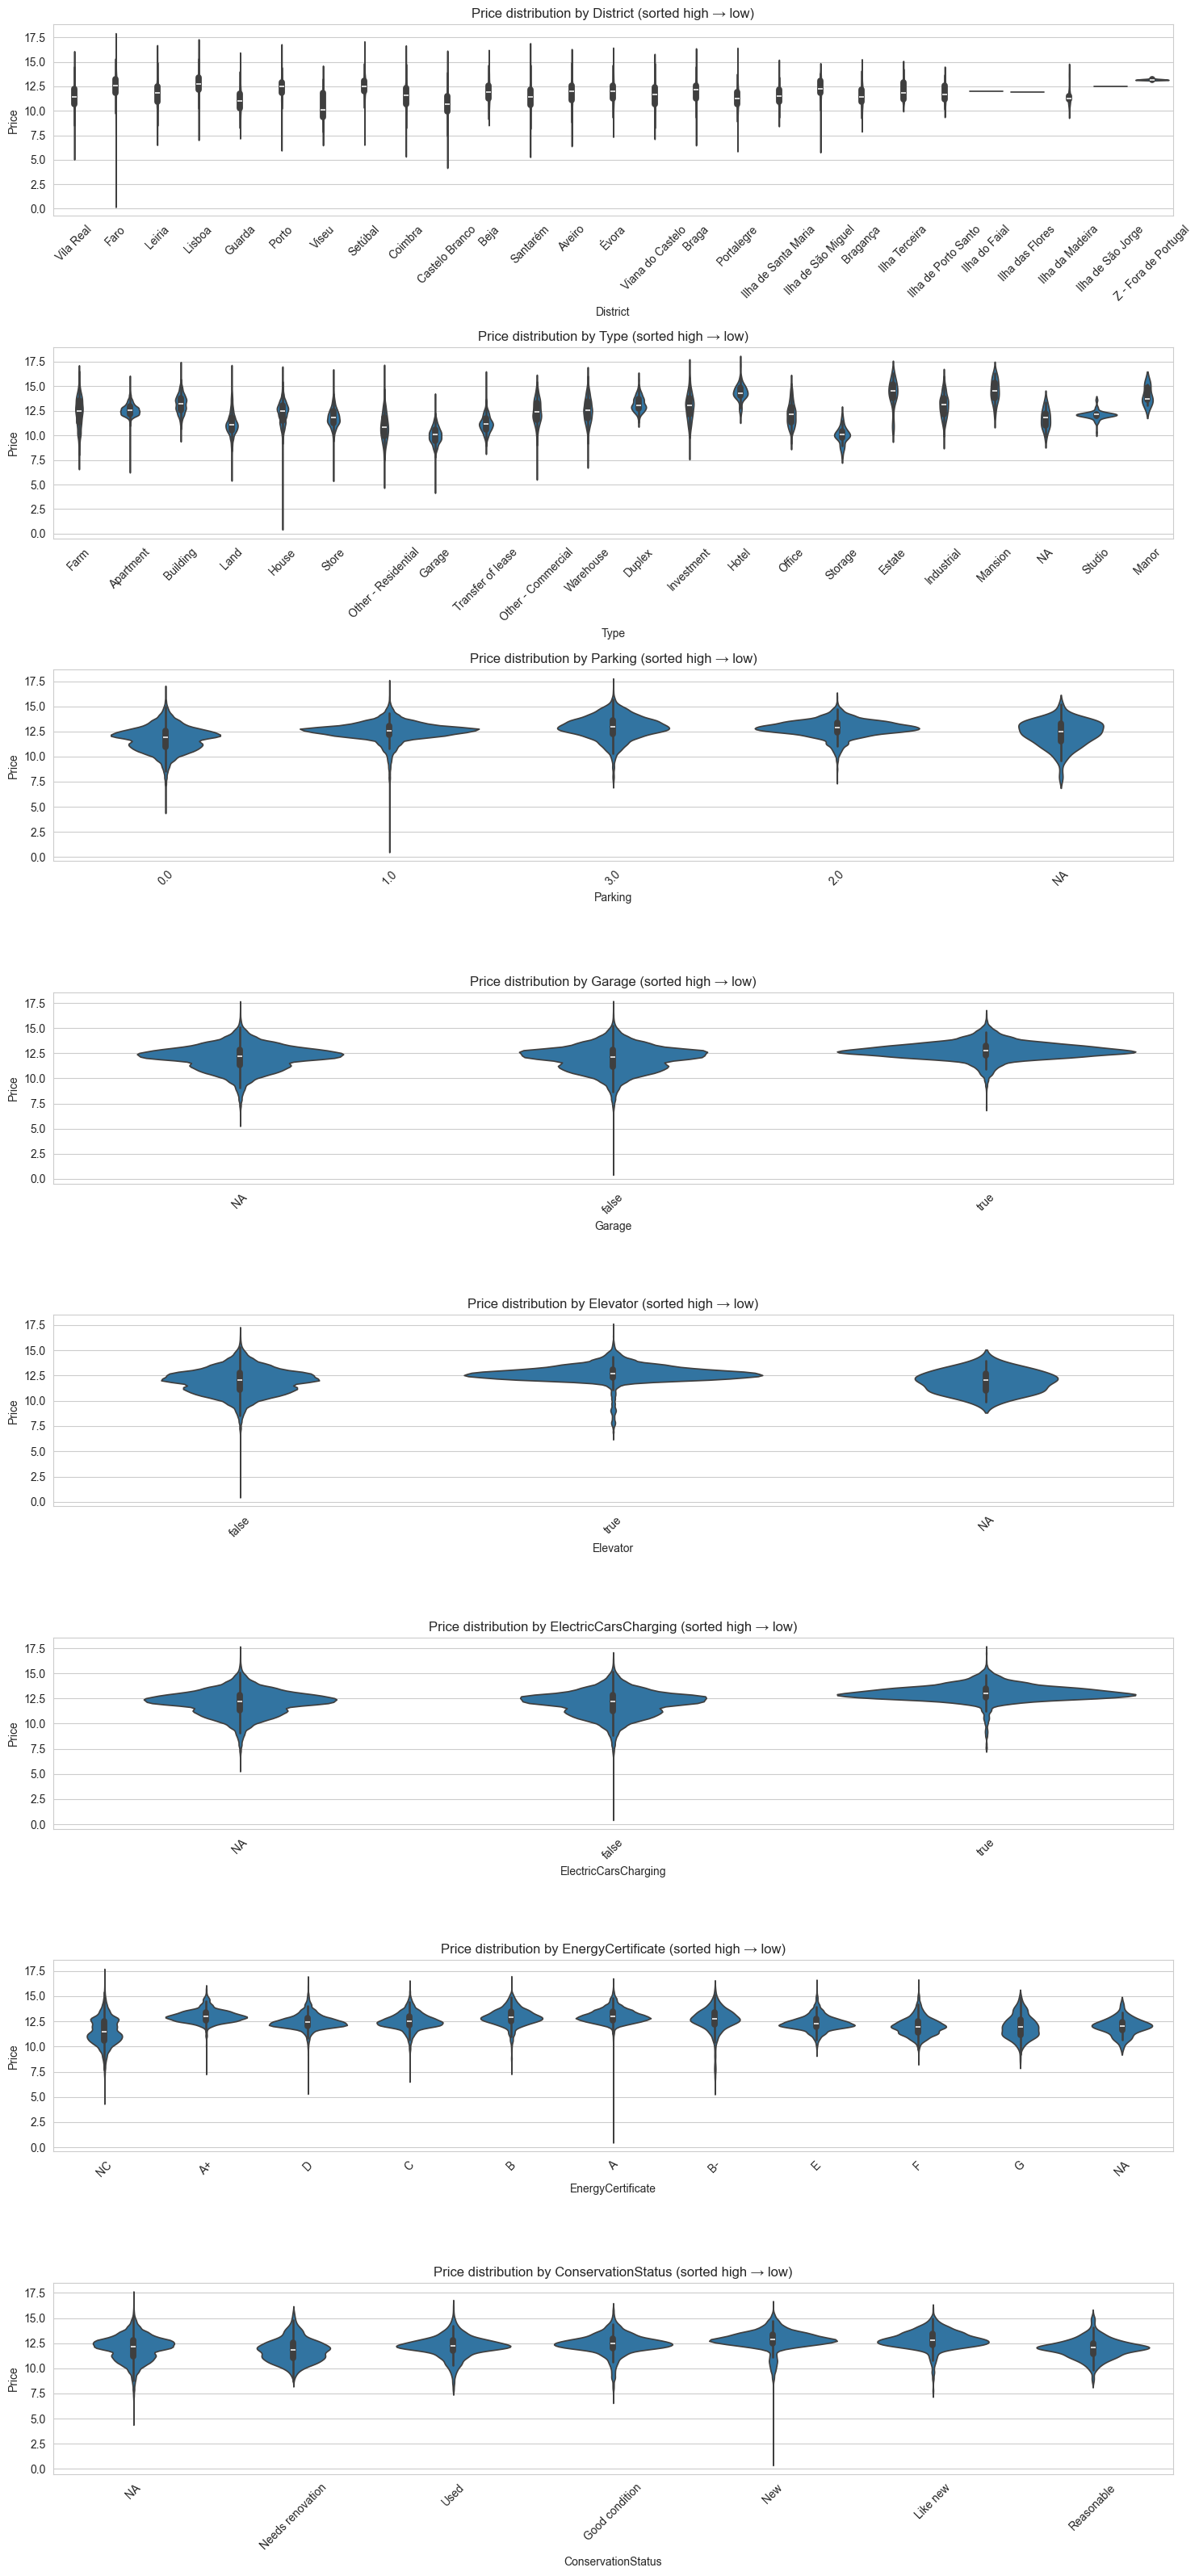

In [46]:
fig, ax = plt.subplots(len(categorical_cols), 1, figsize=(15, 4 * len(categorical_cols)))

for i, col in enumerate(categorical_cols):
    sns.violinplot(data=df,x=col,y=np.log1p(df['Price']),ax=ax[i])

    ax[i].set_title(f"Price distribution by {col} (sorted high → low)")
    ax[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [47]:
for col in categorical_cols:
    print(df.groupby(col).agg(median_price=("Price", "median"),avg_price=("Price", "mean"),count=("Price", "count")).sort_values("median_price", ascending=False))

                      median_price   avg_price  count
District                                             
Z - Fora de Portugal   535,000.000 534,400.000     25
Lisboa                 349,000.000 575,059.557  29887
Faro                   295,000.000 532,013.204   8018
Setúbal                273,000.000 424,717.830  10820
Ilha de São Jorge      260,000.000 260,000.000      1
Porto                  257,900.000 346,569.050  21129
Ilha de São Miguel     200,000.000 321,638.182     55
Braga                  185,000.000 248,505.969  10562
Aveiro                 168,725.000 253,903.420   6842
Évora                  165,000.000 325,815.311   2285
Ilha do Faial          160,000.000 160,000.000      1
Beja                   150,000.000 323,479.374   1261
Ilha das Flores        150,000.000 150,000.000      1
Ilha Terceira          140,000.000 269,045.000     40
Leiria                 140,000.000 227,818.553   6636
Viana do Castelo       120,000.000 214,066.901   3362
Ilha de Porto Santo    115,9

# Hypothesis

Now that our data has been cleaned and transformed we'll construct our Hypothesis, as we have a low tolerance for Type I and Type II errors we'll keep the standard alpha of 0.05 to validate our theory.

## Null Hypothesis N0
- The characteristics of a property in Portugal have no effect on Price

## Alternative Hypothesis N0
- Property characteristics in Portugal have an effect on Price


In [48]:
df_stats = df.copy()
alpha = 0.05

Price has an incredibly long right skew so we'll take the log value in order to bring about a narrower distribution.

In [49]:
df_stats['Price'] = np.log1p(df_stats['Price'])

In [50]:
df_stats[numeric_cols].corr(method='spearman')['Price'].sort_values(ascending=False)

Price                1.000
NumberOfWashrooms    0.594
TotalRooms           0.430
ConstructionYear     0.370
WashroomRatio        0.369
IsLisbonOrPorto      0.279
LivingArea           0.251
FloorNum             0.156
TotalArea            0.053
AgeAtSale           -0.369
Name: Price, dtype: float64

### Is there a difference in price in relation to the number fo bathrooms a property has?

In [51]:
median_val = df_stats['NumberOfWashrooms'].median()

print(median_val)

df_stats['NumberOfWashrooms_bin'] = pd.cut(
    df_stats['NumberOfWashrooms'].fillna(median_val),
    bins=[-np.inf, median_val, np.inf],
    labels=[0, 1]
).astype(int)


1.0


<Axes: xlabel='Price', ylabel='Count'>

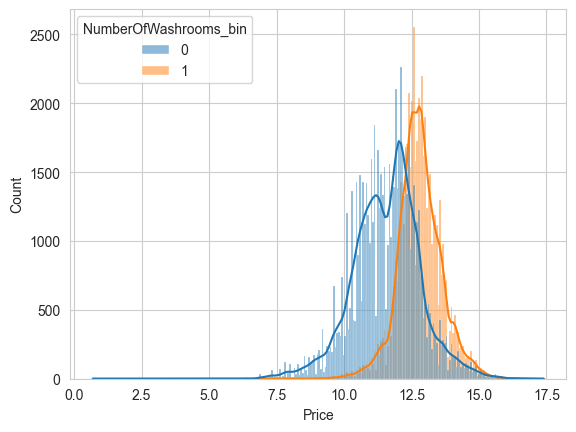

In [52]:
sns.histplot(data=df_stats, x='Price', hue='NumberOfWashrooms_bin', kde=True)

In [53]:
control = df_stats.loc[df_stats['NumberOfWashrooms_bin'] == 0, 'Price']
treatment = df_stats.loc[df_stats['NumberOfWashrooms_bin'] == 1, 'Price']

In [54]:
t_stat, p_value = stats.ttest_ind(treatment, control, equal_var=False)
print(p_value)

0.0


In [55]:
import statsmodels

cm = statsmodels.stats.weightstats.CompareMeans(statsmodels.stats.weightstats.DescrStatsW(treatment), statsmodels.stats.weightstats.DescrStatsW(control))
conf_int = cm.tconfint_diff(alpha=alpha)
print(conf_int)

(np.float64(1.2071755169664835), np.float64(1.2312108552654697))


Yes! There is a statistically significant difference between properties with higher Washrooms in price.

Therefor we can reject the null hypothesis  that the characteristics of a property (In this case the number of bathrooms) have no impact on it's price.

### Is there a difference in price in relation to the type of property?


<Axes: xlabel='Price', ylabel='Count'>

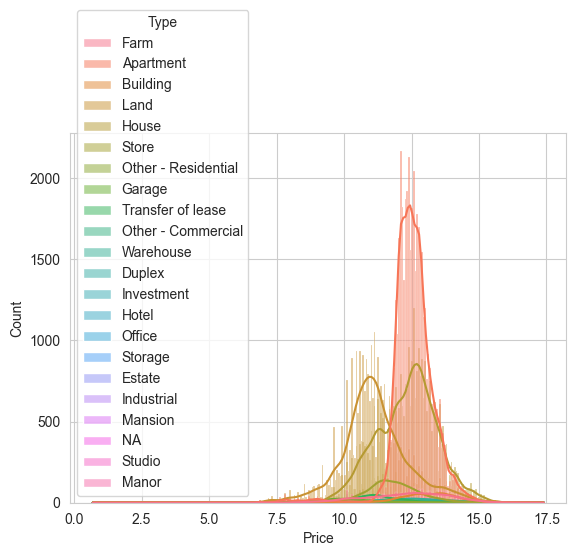

In [56]:
sns.histplot(data=df_stats, x='Price', kde=True, hue='Type')

When taking the log of Prices and observe the distributions across different property types we see there's a mix of normal and non normal distributions. Given that prices vary depending on type and the variance is not homogenous we'll use a Kruskal-Wallis test to statistically tell us whether if there are any differences in the median price.




In [57]:
import scipy.stats as stats

groups = [
    df_stats.loc[df_stats['Type'] == t, 'Price'].dropna()
    for t in df_stats['Type'].unique()
]

stat, p = stats.kruskal(*groups)

print(f"Kruskal-Wallis statistic = {stat:.6f}, p-value = {p:.8f}")


Kruskal-Wallis statistic = 33084.085399, p-value = 0.00000000


Yes ! We get an incredibly low p-value which is much lower than our 0.05 alpha. This means we can reject the null hypothesis that the charcterictics of a propoerty (In this case the type of property) have no impact on it's price.

In [58]:
# Wipe unneeded dataframe from Memory
lst = [df_stats]
del df_stats
del lst

# Machine Learning

Let’s start by building a baseline model so we can get some initial metrics to compare against our later models. Earlier, when we looked at the Spearman correlations, we saw stronger relationships than with the Pearson test, which suggests the data isn’t very linear. Because of that and the fact the dataset has quite a few categorical fields and missing values, it doesn't make sense to create a linear model.

Instead, we’ll use a Random Forest as our baseline. Random Forests handle non-linear relationships really well, and they’re also more robust with categorical variables and missing data, which makes them a good fit for this dataset. They also tend to perform alright on default parameters which also makes a compelling choice as our baseline!



In [59]:
X = pd.DataFrame(df.drop(columns=["Price"]))
y = pd.DataFrame(df["Price"])


categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

df[numeric_cols] = df[numeric_cols].astype("float")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [60]:
X_train.shape, X_test.shape

((88432, 17), (37900, 17))

In [61]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_cols),

        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median'))
        ]), numeric_cols)
    ]
)

preprocessor.set_output(transform='pandas')

,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'constant'
,fill_value,'NA'


In [62]:
model = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [63]:
y_pred = model.predict(X_test)

In [64]:
print(f"Overall Price Mean: €{df['Price'].mean():,.0f}\n")

hf.summarise_model(y_test, y_pred)

Overall Price Mean: €359,743



,Metric,Value
0,MAE,"149,908.666"
1,RMSE,"463,466.892"
2,R²,0.459


Now we have our baseline model we have something we can compare to.

These results tell us that we have very large variability in our Price given the high MAE and RSME. However a R² of 0.51 tells us that around half of the variation in property prices can be explained by our model the rest being noise. That's pretty decent!

### Let's find a better model

In [65]:
model_params = {
    'elastic': {
        'model': ElasticNet(max_iter=5000),
        'params': {
            'alpha': [0.01, 0.1, 1],    # ↓ smaller grid
            'l1_ratio': [0.2, 0.8]      # ↓ only low + high mixing
        }
    },

    'rf': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [200, 400],        # ↓ one solid choice
            'max_depth': [10, 30],      # ↓ shallow vs full
            'min_samples_leaf': [1, 4],   # ↓ small variation
        }
    },

    'gbr': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [200, 500],        # ↓ single value
            'learning_rate': [0.05, 0.1],      # ↓ optimal mid-range
            'max_depth': [2, 3, 5],          # ↓ small depth search
        }
    },

    'xgb': {
        'model': XGBRegressor(tree_method='hist'),
        'params': {
            'n_estimators': [300, 500],        # ↓ one strong choice
            'learning_rate': [0.05, 0.1],      # ↓ safest value
            'max_depth': [4, 6, 10],          # ↓ only two depths
            'subsample': [0.8],           # ↓ most common best
            'colsample_bytree': [0.8],    # ↓ same
        }
    },
}


In [66]:
scores = []

for name, mp in model_params.items():
    print(f"Beep Bop Boop Beep ... Training {name}")

    pipe = Pipeline([
        ('prep', preprocessor),
        ('model', mp['model'])
    ])

    param_grid = {f"model__{k}": v for k, v in mp['params'].items()}

    clf = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    clf.fit(X_train, y_train)

    scores.append({
        'model': name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })



Beep Bop Beep Boop ... Training elastic
Beep Bop Beep Boop ... Training rf
Beep Bop Beep Boop ... Training gbr
Beep Bop Beep Boop ... Training xgb


In [67]:
results = pd.DataFrame(scores)
results['rmse'] = -results['best_score']
results = results.sort_values('rmse')

print("\n\nModel Leaderboard (Lower RMSE = Better):")
results[['model', 'rmse', 'best_params']]



Model Leaderboard (Lower RMSE = Better):


,model,rmse,best_params
3,xgb,"466,149.594","{'model__colsample_bytree': 0.8, 'model__learn..."
2,gbr,"472,853.307","{'model__learning_rate': 0.1, 'model__max_dept..."
1,rf,"478,512.472","{'model__max_depth': 30, 'model__min_samples_l..."
0,elastic,"4,912,022.229","{'model__alpha': 1, 'model__l1_ratio': 0.2}"


We're not seeing any improvements from our baseline model.

After doing some research CatBoostRegressor is apparently a good alternative model to try as it handles categorical and missing data very well. We'll also take the log as Price given that it's right skewed, maybe it'll make a difference.

Let's give it a try!



# CatBoostRegressor

In [68]:
X = pd.DataFrame(df.drop(columns=["Price"]))
y = np.log1p(df["Price"])

categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((101065, 17), (25267, 17))

In [69]:
cat_features = [X_train.columns.get_loc(col) for col in categorical_cols]

cat_model = CatBoostRegressor(verbose=False,train_dir=None)
cat_model.fit(X_train, y_train,cat_features=cat_features,eval_set=(X_test, y_test),early_stopping_rounds=100)

y_cat_pred = np.expm1(cat_model.predict(X_test))

In [70]:
# Here I'm just reversing the Log applied to Price so that we can interpret results better
y_test_actual = np.expm1(y_test)

model_catboost_df = hf.summarise_model(y_test_actual, y_cat_pred)
model_catboost_df['Model'] = 'Baseline CatBoostRegressor'
model_catboost_df

,Metric,Value,Model
0,MAE,"141,925.571",Baseline CatBoostRegressor
1,RMSE,"441,200.253",Baseline CatBoostRegressor
2,R²,0.474,Baseline CatBoostRegressor


We're getting some marginal improvements but let's see if there's any hyper tuning we can do get even better results.

## Bayesian Optimisation

Bayesian Optimisation is a smarter, more efficient way to tune hyperparameters compared to grid or randomized search. Instead of blindly searching through the space, it uses past results to decide what hyperparameters to try next—focusing on areas that are likely to yield better performance.

Let's see if we can get better results with our CarBoostRegressor with BO.

In [71]:
# This helps our model run faster!
cat_features_idx = [X_train.columns.get_loc(c) for c in categorical_cols]

In [72]:
param_space = {
    "depth": Integer(4, 8),
    "learning_rate": Real(0.01, 0.2, prior="log-uniform"),
    "l2_leaf_reg": Real(1e-3, 3, prior="log-uniform"),
    "iterations": Integer(200, 600),
}

bo_model = CatBoostRegressor(
    verbose=False,
    train_dir=None,
    loss_function="RMSE",
    random_state=42
)

In [73]:
bayes = BayesSearchCV(
    estimator=bo_model,
    search_spaces=param_space,
    cv=KFold(2, shuffle=True, random_state=42),
    scoring="neg_root_mean_squared_error",
    n_iter=10,
    random_state=42,
    refit=True
)

# Fit with cat_features passed through to CatBoost
bayes.fit(X_train,y_train,cat_features=cat_features_idx)

,estimator,<catboost.cor...t 0x161b2a710>
,search_spaces,"{'depth': Integer(low=4...m='normalize'), 'iterations': Integer(low=2...m='normalize'), 'l2_leaf_reg': Real(low=0.00...m='normalize'), 'learning_rate': Real(low=0.01...m='normalize')}"
,optimizer_kwargs,None
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,fit_params,None
,n_jobs,1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,KFold(n_split... shuffle=True)


In [74]:
print("Best params:", bayes.best_params_)
print("Best score:", -bayes.best_score_)

Best params: OrderedDict({'depth': 7, 'iterations': 553, 'l2_leaf_reg': 0.011349944606987317, 'learning_rate': 0.1728107818436132})
Best score: 0.6798818069192154


In [75]:
best_model = bayes.best_estimator_

y_pred_tuned_log = best_model.predict(X_test)
y_pred_tuned = np.expm1(y_pred_tuned_log)


In [76]:
model_catboost_tuned_df = hf.summarise_model(y_test_actual, y_pred_tuned)
model_catboost_tuned_df['Model'] = 'Tuned CatBoostRegressor'

model_summary = pd.concat([model_catboost_tuned_df, model_catboost_df], ignore_index=True)
model_summary


,Metric,Value,Model
0,MAE,"140,097.805",Tuned CatBoostRegressor
1,RMSE,"435,193.025",Tuned CatBoostRegressor
2,R²,0.488,Tuned CatBoostRegressor
3,MAE,"141,925.571",Baseline CatBoostRegressor
4,RMSE,"441,200.253",Baseline CatBoostRegressor
5,R²,0.474,Baseline CatBoostRegressor


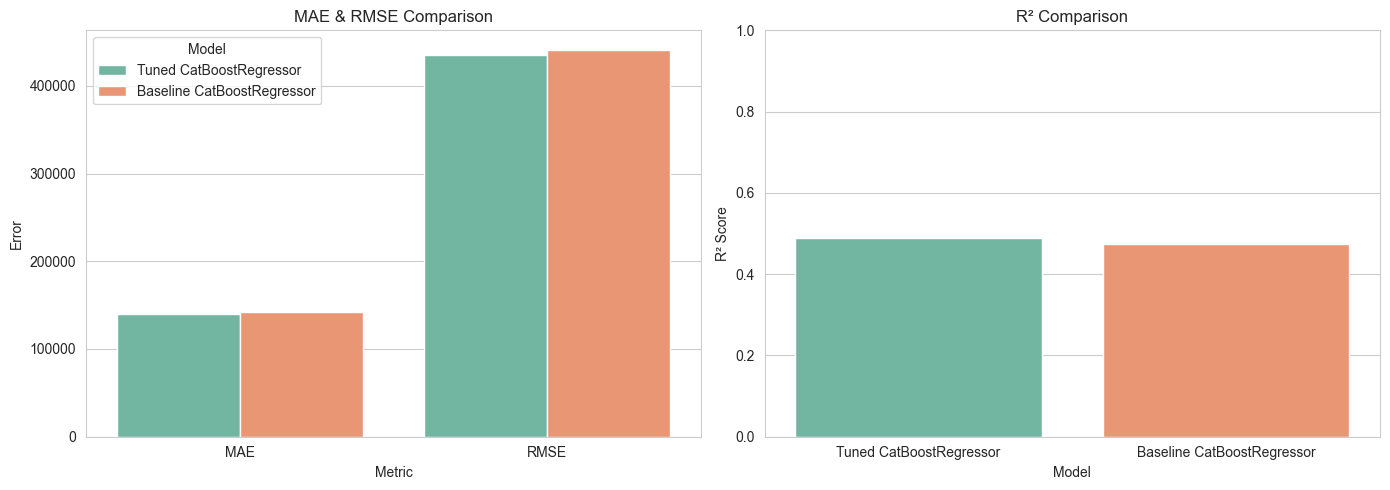

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left Chart MAE & RMSE
sns.barplot(
    data=model_summary[model_summary["Metric"] != "R²"],
    x="Metric",
    y="Value",
    hue="Model",
    ax=axes[0],
    palette="Set2"
)
axes[0].set_title("MAE & RMSE Comparison")
axes[0].set_ylabel("Error")

# Right Chart R²
sns.barplot(
    data=model_summary[model_summary["Metric"] == "R²"],
    x="Model",
    y="Value",
    ax=axes[1],
    palette="Set2"
)
axes[1].set_ylim(0, 1)
axes[1].set_title("R² Comparison")
axes[1].set_ylabel("R² Score")

plt.tight_layout()
plt.show()


Our default CatBoost Regressor, using only the out-of-the-box parameters, did not outperform the other baseline models and was only slightly behind XGBoost. However, once we applied Bayesian optimization, the model improved substantially. With the optimized hyperparameters we reduced RMSE by at least €5,000 and a small bump in R².

Given this improvement, the model we will deploy in the application is the Bayesian-optimized CatBoost Regressor, as it delivers the strongest overall performance.

# X Shap for CatBoost Regressor Explainabiltiy

In [78]:
X_shap = X_test.sample(1000, random_state=42)

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_shap)

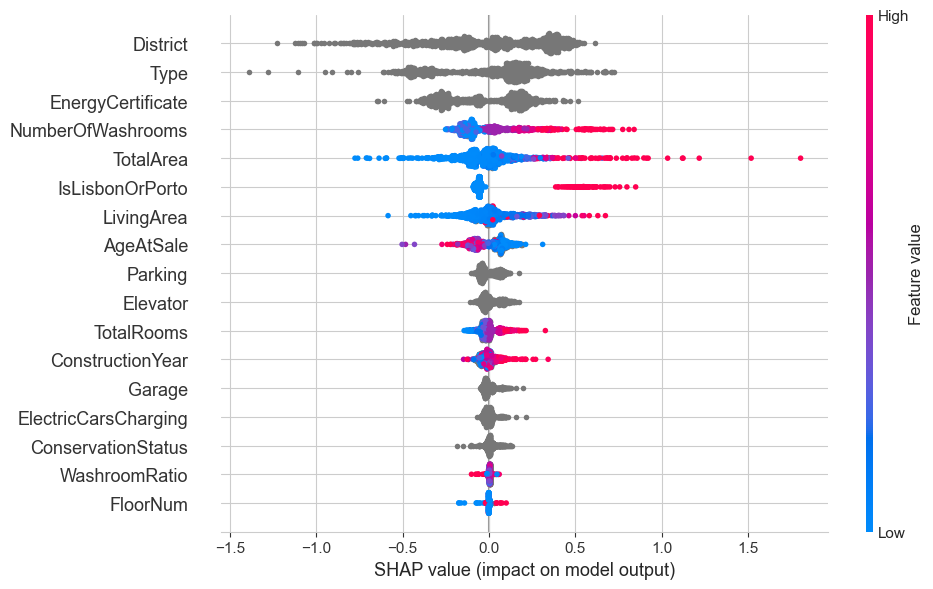

In [79]:
shap.summary_plot(shap_values, X_shap, plot_size=(10,6))

The SHAP summary plot shows, in descending order, the most important features that drove predictions in our tuned CatBoost Regressor model.

Our top features were:
1. District
2. Type
3. Energy Certificate
4. Number of Washrooms
5. Total Area

Interestingly the three most important features are all categorical. Following we also see a roughly linear relationship for:
- Number of washrooms
- Total area
- Whether the property is located in Lisbon or Porto

Overall, this means that:
- Properties with more washrooms
- Properties with a larger area
- Properties based in Lisbon or Porto

tend to have higher predicted valuations in our model.

In [80]:
shap.initjs()

row = X_shap.iloc[[0]]
shap_values_single = explainer.shap_values(row)

shap.force_plot(explainer.expected_value,shap_values_single,row)


# Prediction

In [81]:
feature_order = X_train.columns.tolist()

example_property = {
    "District": "Porto",
    "Type": "Appartment",
    "EnergyCertificate": "A+",
    "TotalArea": 150,
    "NumberOfWashrooms": 1,
    "AgeAtSale": 2,
    "LivingArea": 90,
    "Parking": 1,
    "ConstructionYear": 2005,
    "Elevator": 0,
    "TotalRooms": 3,
    "HasParking": 1,
    "IsLisbonOrPorto": 1,
    "ConservationStatus": "Good",
    "Garage": 0,
    "ElectricCarsCharging": 0,
    "WashroomRatio": 0.5,
    "FloorNum": 10,
}

example_df = pd.DataFrame(example_property,index=[0])


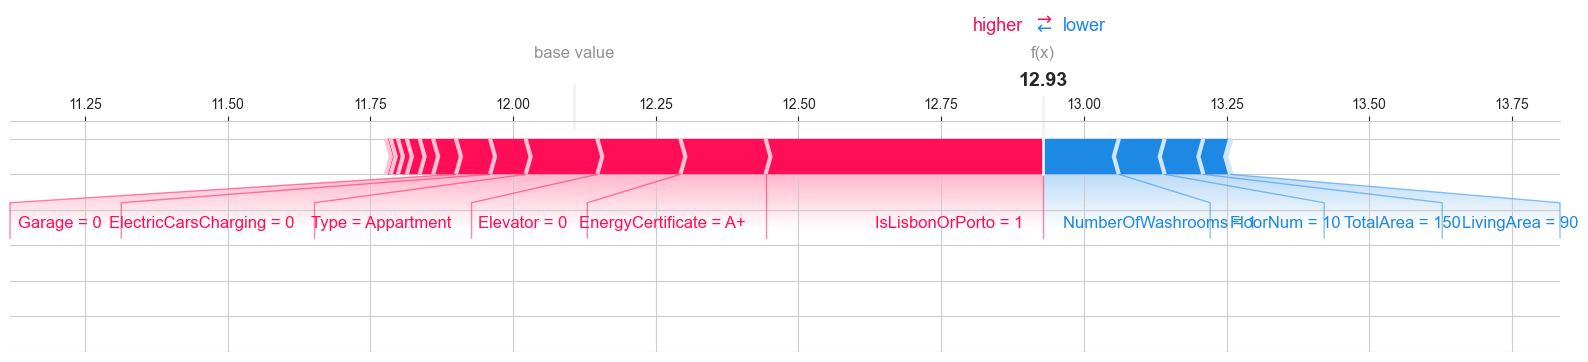

Predicted Property Price: €564,805


In [82]:
predicted_price = hf.predict_with_explanation(
    example_property,
    best_model,
    explainer,
    feature_order
)


print(f"Predicted Property Price: €{predicted_price:,.0f}")


# Model Serialization

In [83]:
best_model.save_model("/Users/guywinfield/PycharmProjects/Data-Science-Projects/Analyses/Portugal Housing Prices/model.cbm")

In [84]:
import joblib
import shap

explainer = shap.TreeExplainer(best_model)
joblib.dump(explainer, "/Users/guywinfield/PycharmProjects/Data-Science-Projects/Analyses/Portugal Housing Prices/Application/explainer.pkl")

['/Users/guywinfield/PycharmProjects/Data-Science-Projects/Analyses/Portugal Housing Prices/Application/explainer.pkl']

In [85]:
import json

json.dump({
    "categorical_cols": list(categorical_cols),
    "feature_order": list(feature_order)
}, open("/Users/guywinfield/PycharmProjects/Data-Science-Projects/Analyses/Portugal Housing Prices/Application/metadata.json", "w"))


## ✅ Final Summary

- We trained and evaluated a CatBoost regressor to predict property prices in Portugal.
- The target variable was log-transformed using `log1p(Price)` to reduce skew and stabilise variance.
- A unified preprocessing step ensured consistent handling of missing values and categorical variables.
- The **baseline CatBoost model** performed reasonably well but was improved by **Bayesian optimisation**, which:
  - reduced RMSE by approximately €5000,
  - improved R² on the test set.
- Feature importance analysis highlighted:
  - District, Type, Energy Certificate, Total Area, and Number of Washrooms as key drivers of price.
- Using SHAP values, we can now:
  - explain individual predictions,
  - show which features push the price estimate up or down for each property.

This structure gives us a reproducible workflow we can later turn into an API or a simple web app for price estimation.
